# MNIST Fastshap vs FastShap with DP

In [1]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch


# import from parent level
import sys
import copy

sys.path.append("../")
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from utils import prepare_data
from scipy.stats import spearmanr
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from fastshap.image_surrogate_DP import ImageSurrogate_DP

/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %pip install python-dotenv
%load_ext dotenv
%dotenv

import torch

print(torch.cuda.device_count())

1


### Functions

In [3]:
# Faithfulness evaluation
class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.exp(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value=0.2):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


def process_explainer(
    explanation_file_name, explainer, model, x, y, index, base_value, base_path
):
    if not os.path.isfile(
        f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
    ):
        fastshap_explanation = explainer.shap_values(x)
        fastshap_explanation = fastshap_explanation[0]  # [:, y]
        torch.save(
            fastshap_explanation,
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt",
        )
    else:
        fastshap_explanation = torch.load(
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
        )

    # if not os.path.isfile(
    #     f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    # ):
    #     faithfulness = compute_faithfulness(
    #         x,
    #         y,
    #         fastshap_explanation,
    #         model,
    #         base_value=base_value,
    #     )
    #     torch.save(
    #         faithfulness,
    #         f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt",
    #     )
    # else:
    #     faithfulness = torch.load(
    #         f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    #     )
    return fastshap_explanation  # , faithfulness

In [4]:
class Args:
    def __init__(self):
        self.dataset_name = "mnist"
        self.sweep = True


args = Args()
args.seed = 42
args.sweep = False
args.dataset_name = "mnist"
(
    train_set,
    val_set,
    test_set,
) = prepare_data(args)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        output = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return output

In [5]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = np.std(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = np.std(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = np.std(faithfulness_eps_1)

    mean_eps_2 = np.mean(faithfulness_eps_2)
    std_eps_2 = np.std(faithfulness_eps_2)

    mean_eps_3 = np.mean(faithfulness_eps_3)
    std_eps_3 = np.std(faithfulness_eps_3)

    mean_eps_4 = np.mean(faithfulness_eps_4)
    std_eps_4 = np.std(faithfulness_eps_4)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = np.std(faithfulness_eps_5)

    mean_eps_10 = np.mean(faithfulness_eps_10)
    std_eps_10 = np.std(faithfulness_eps_10)

    mean_eps_100 = np.mean(faithfulness_eps_100)
    std_eps_100 = np.std(faithfulness_eps_100)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 05": [mean_eps_05],
        "Eps. 1": [mean_eps_1],
        "Eps. 2": [mean_eps_2],
        "Eps. 3": [mean_eps_3],
        "Eps. 4": [mean_eps_4],
        "Eps. 5": [mean_eps_5],
        "Eps. 10": [mean_eps_10],
        "Eps. 100": [mean_eps_100],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 05": [std_eps_05],
        "Eps. 1": [std_eps_1],
        "Eps. 2": [std_eps_2],
        "Eps. 3": [std_eps_3],
        "Eps. 4": [std_eps_4],
        "Eps. 5": [std_eps_5],
        "Eps. 10": [std_eps_10],
        "Eps. 100": [std_eps_100],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()


def plot_error_bar(labels, results_mean, results_std, y_label, title, y_lim=None):
    means = [results_mean[label] for label in labels]
    errors = [results_std[label] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel(y_label, fontsize=14)
    plt.title(
        title,
        fontsize=16,
    )
    # y lim
    if y_lim:
        plt.ylim(y_lim)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.xticks(rotation=90)

    plt.show()

In [6]:
def load_data(
    private_model: bool,
    private_surrogate: bool,
    explainer_privacy_levels: list,
    base_path: str,
    model_name: str,
    surrogate_name: str,
    explainer_name: str,
    device: str,
    eps_bb: str = "",
):
    loaded_data = {}
    loaded_data["private_model"] = private_model
    loaded_data["private_surrogate"] = private_surrogate
    private_model_str = "private_model_" if private_model else ""

    if os.path.isfile(
        f"{base_path}bb/{model_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print("Loading saved model")
        model = torch.load(
            f"{base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to("cpu")
        model_aix = aix_model(model)

    # Surrogate model without DP
    if os.path.isfile(
        f"{base_path}/surrogate/{surrogate_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pt"
    ):
        print("Loading saved surrogate model")
        surr = torch.load(
            f"{base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pt"
        ).to(device)
        surrogate = ImageSurrogate_DP(surr, width=28, height=28, superpixel_size=2)

    loaded_data["model"] = model
    loaded_data["model_aix"] = model_aix
    loaded_data["surrogate"] = surrogate

    for eps in explainer_privacy_levels:
        # DP 0.5
        if os.path.isfile(f"{base_path}/explainer/{explainer_name}_{eps}.pt"):
            print("Loading saved explainer model")
            explainer = torch.load(
                f"{base_path}/explainer/{explainer_name}_{eps}.pt"
            ).to(device)
            fastshap = FastSHAP(
                explainer, surrogate, normalization="none", link=nn.Softmax(dim=-1)
            )
            loaded_data[f"explainer_{eps}"] = fastshap
        else:
            print(
                f"Explainer model not found: {base_path}/explainer/{explainer_name}_{private_model_str}{eps}.pt"
            )
    return loaded_data

In [7]:
def get_explanations(
    model_predictions: list, X_test, loaded_data: dict, base_value: float
):
    for privacy_level in explainer_privacy_levels:
        faithfulness = []
        explanations = []
        for index, (x, y) in enumerate(zip(X_test, model_predictions)):
            # y = 0 if not y else 1
            x = x[0]

            shap_NO_DP = process_explainer(
                f"private_model_{loaded_data['private_model']}_surrogate_{loaded_data['private_surrogate']}_explainer_{privacy_level}",
                loaded_data[f"explainer_{privacy_level}"],
                loaded_data["model_aix"],
                x,
                y,
                index,
                base_value,
                base_path="../artifacts/mnist/",
            )
            explanations.append(copy.deepcopy(shap_NO_DP))
            # faithfulness.append(faithfulness_NO_DP)
            loaded_data[f"explanations_{privacy_level}"] = explanations
            loaded_data[f"faithfulness_{privacy_level}"] = faithfulness

In [8]:
def plot_base_explainer_shap_values(
    loaded_data, explainer_privacy_levels, X_test, feature_names, title
):
    explanations = []
    for index in range(len(X_test)):
        fastshap_NO_DP = loaded_data["explanations_NO_DP"][index]
        # compute the absolute values of the shap values
        fastshap_NO_DP = np.abs(fastshap_NO_DP)
        explanations.append(fastshap_NO_DP)

    # mean of the absolute values of the shap values
    mean_explanations = np.mean(explanations, axis=0)
    # sort the mean_explanations and the corresponding feature names
    sorted_indices = np.argsort(mean_explanations)[::-1]
    print(len(sorted_indices))
    print(len(feature_names))
    # plot the mean shap values with the corresponding feature names in sorted indices
    plt.figure(figsize=(10, 6))
    plt.bar(
        [feature_names[i] for i in sorted_indices], mean_explanations[sorted_indices]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Mean SHAP Value")
    plt.title(title)
    plt.show()

In [9]:
def create_dictionaries_metrics(explainer_privacy_levels, metrics, current_metric):
    mean = {}
    std = {}
    for privacy_level in explainer_privacy_levels:
        mean["Epsilon " + privacy_level.split("_")[1]] = np.mean(
            metrics[current_metric + privacy_level]
        )
        std["Epsilon " + privacy_level.split("_")[1]] = np.std(
            metrics[current_metric + privacy_level]
        )
    return mean, std

### Load Data

In [30]:
explainer_privacy_levels = [
    "NO_DP",
    # "DP_05",
    # "DP_1",
    # "DP_2",
    # "DP_3",
    # "DP_4",
    # "DP_5",
    # "DP_10",
    # "DP_100",
]

# loaded_data_private_model = load_data(
#     private_model=True,
#     private_surrogate=True,
#     explainer_privacy_levels=explainer_privacy_levels,
#     base_path="../artifacts/mnist/",
#     model_name="bb_mnist",
#     surrogate_name="mnist_surrogate",
#     explainer_name="mnist_explainer",
#     device="cuda",
#     eps_bb="DP_1",
# )

loaded_data_NO_DP_bb = load_data(
    private_model=False,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../artifacts/mnist/",
    model_name="bb_mnist",
    surrogate_name="mnist_surrogate",
    explainer_name="mnist_explainer",
    device="cuda",
)

Loading saved model


/tmp/ipykernel_1383619/2222763574.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(


Loading saved surrogate model
Loading saved explainer model


/tmp/ipykernel_1383619/2222763574.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  surr = torch.load(
/tmp/ipykernel_1383619/2222763574.py:52: FutureWarning: You are usi

## Make Predictions

In [33]:
from torch.utils.data import (
    DataLoader,
)

test_loader = (
    DataLoader(test_set, batch_size=128, shuffle=False)
    if test_set is not None
    else None
)


def get_model_predictions(model):
    model_predictions = []
    for x, label in test_loader:
        model_prediction = model(x)
        model_predictions.append(model_prediction)
    return model_predictions


# loaded_data_private_model["model_predictions"] = get_model_predictions(
#     model=loaded_data_private_model["model"]
# )
loaded_data_NO_DP_bb["model_predictions"] = get_model_predictions(
    model=loaded_data_NO_DP_bb["model"]
)

In [34]:
loaded_data_NO_DP_bb.keys()

dict_keys(['private_model', 'private_surrogate', 'model', 'model_aix', 'surrogate', 'explainer_NO_DP', 'model_predictions'])

## Compute Explanations

In [35]:
# get_explanations(
#     model_predictions=loaded_data_private_model["model_predictions"],
#     X_test=test_loader,
#     loaded_data=loaded_data_private_model,
#     base_value=0.2,
# )

get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=test_loader,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=0.2,
)

## Compute Metrics

In [15]:
# feature_names.append("bias")
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_private_model,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for Private Model",
# )

In [16]:
# top_k_private_BB = [
#     "edu_level",
#     "sex_binary",
#     "economic_status",
#     "age",
# ]

In [17]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_NO_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
# )

In [18]:
# top_k_non_private_bb = [
#     "edu_level",
#     "sex_binary",
#     "age",
#     "economic_status",
# ]

# Images


In [36]:
loaded_data_NO_DP_bb.keys()

dict_keys(['private_model', 'private_surrogate', 'model', 'model_aix', 'surrogate', 'explainer_NO_DP', 'model_predictions', 'explanations_NO_DP', 'faithfulness_NO_DP'])

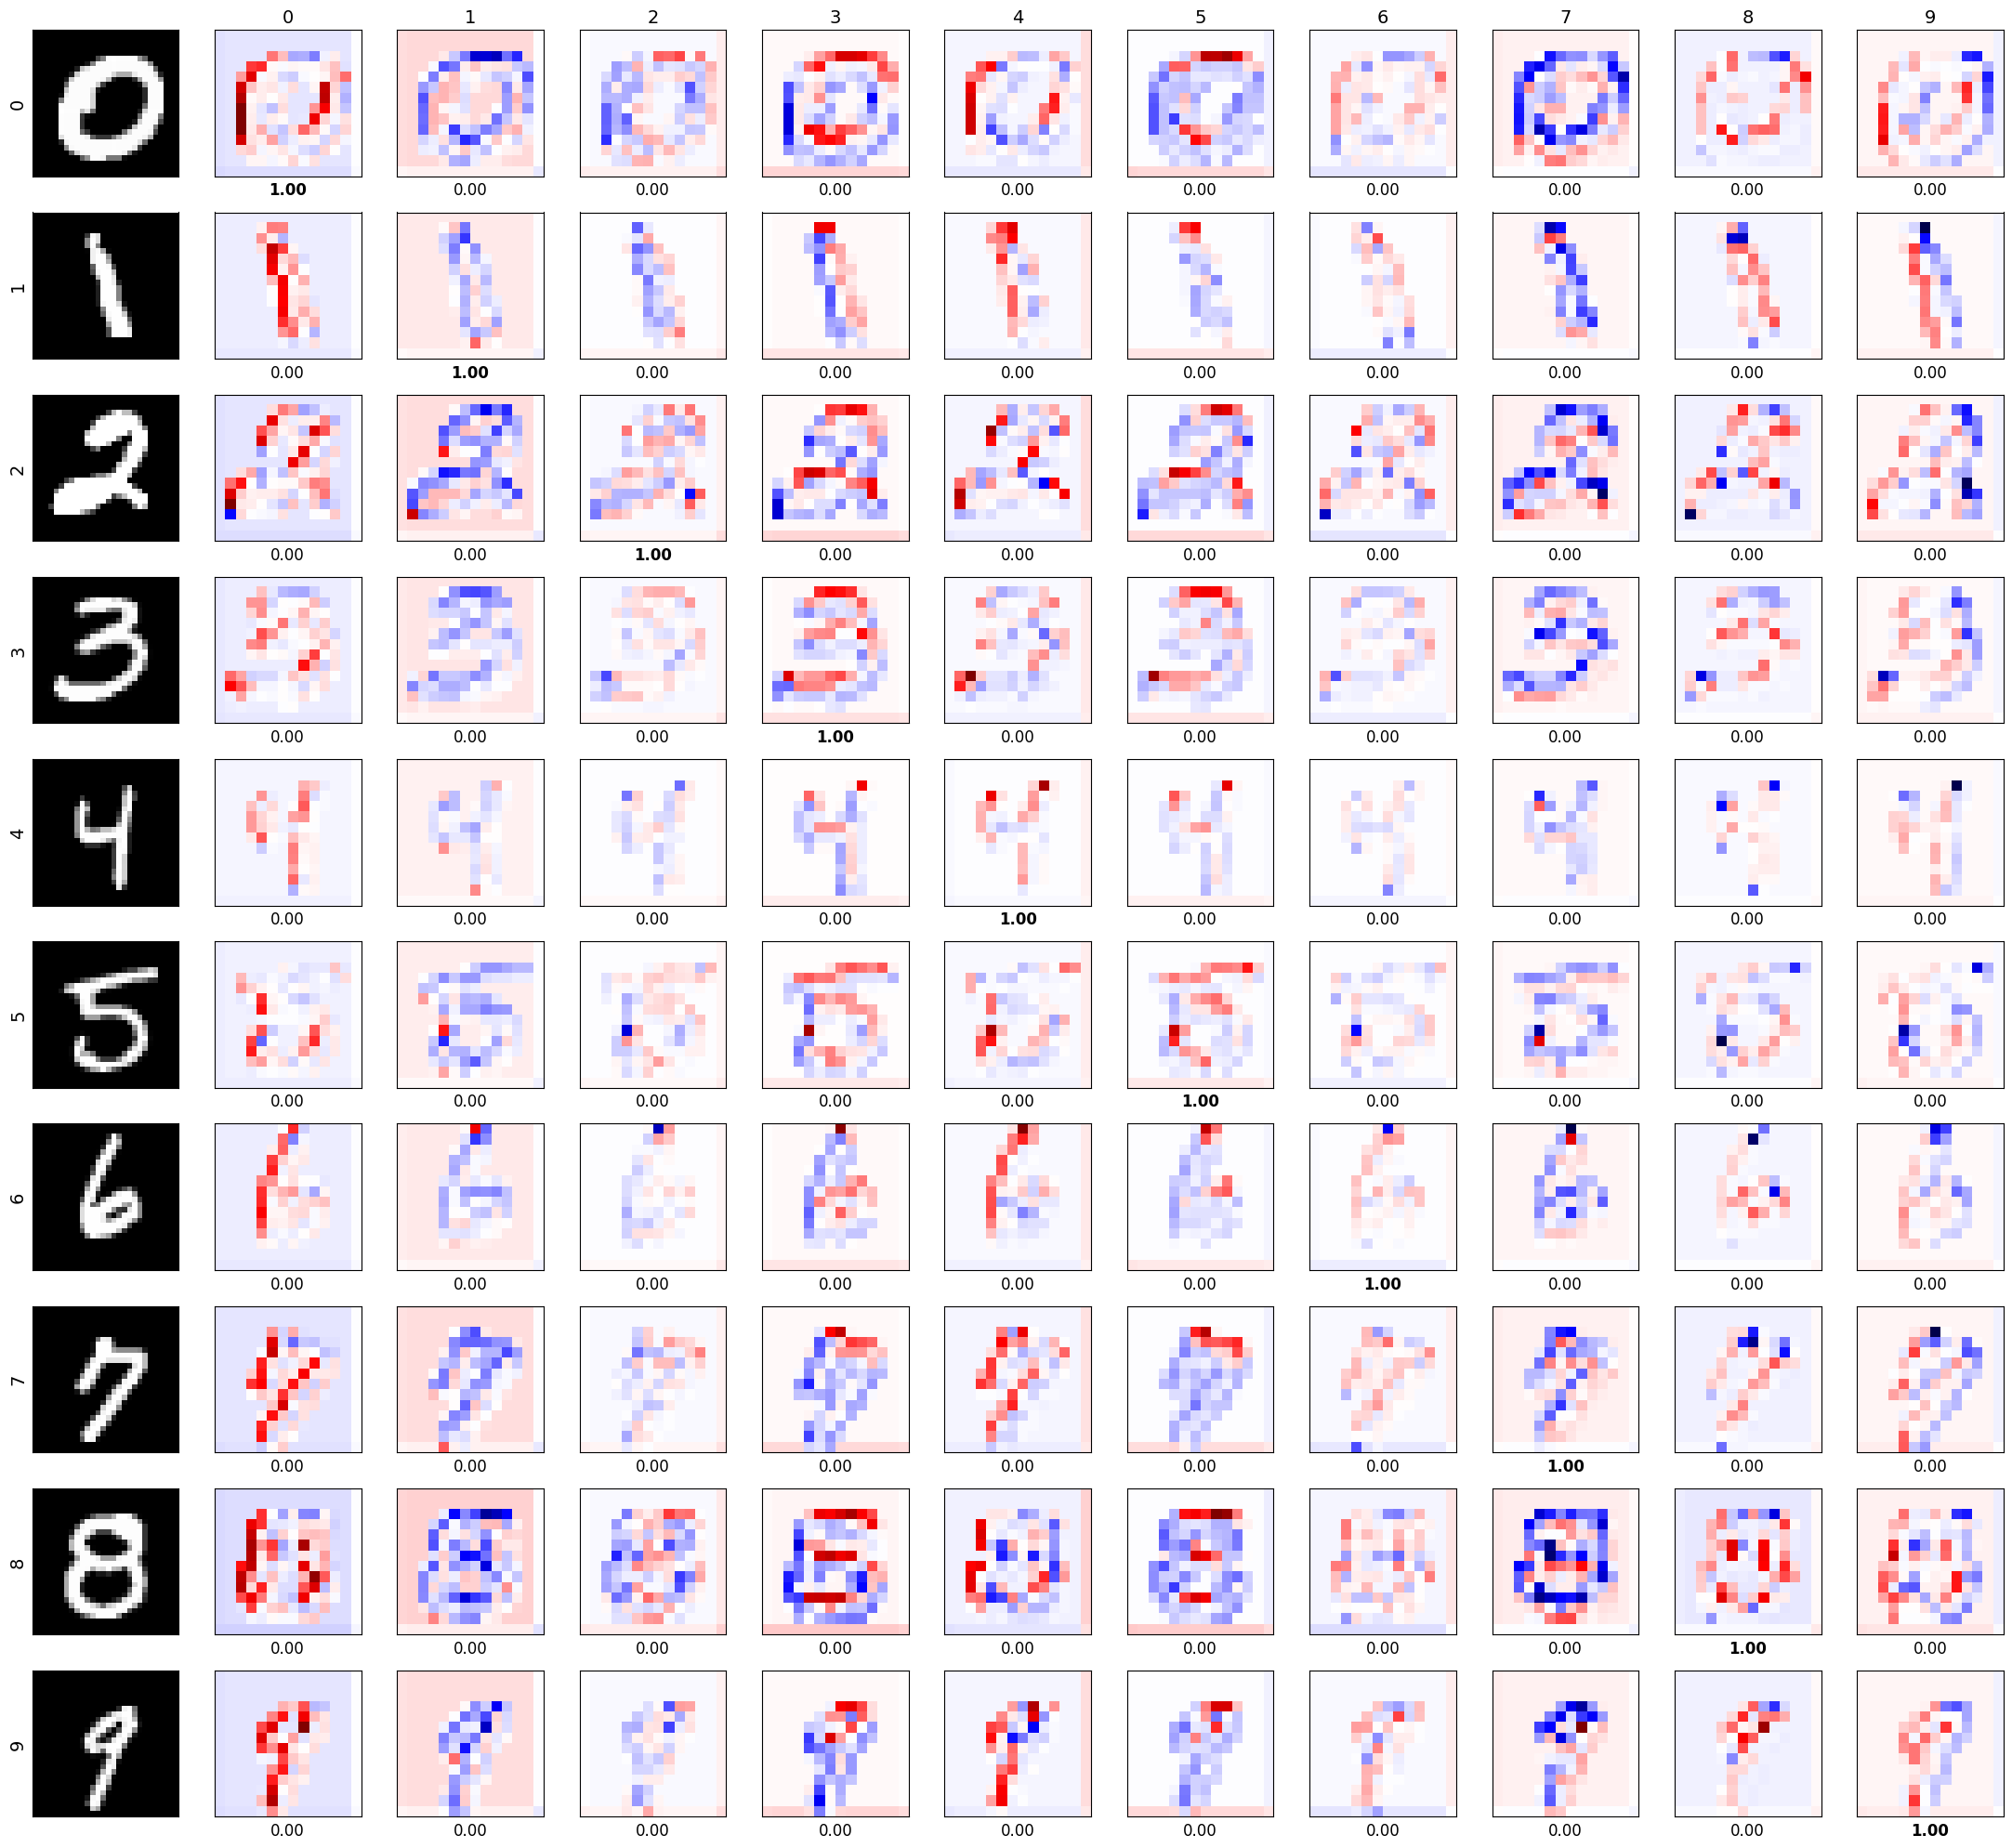

In [37]:
# Select one image from each class
dset = test_set
targets = np.array(test_set.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = loaded_data_NO_DP_bb["explainer_NO_DP"].shap_values(x.to("cuda"))

# Get predictions
pred = (
    loaded_data_NO_DP_bb["surrogate"](
        x.to("cuda"),
        torch.ones(
            num_classes,
            loaded_data_NO_DP_bb["surrogate"].num_players,
            device="cuda",
        ),
    )
    .softmax(dim=1)
    .cpu()
    .data.numpy()
)

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
    ]
    mean = np.array([0.1307, 0.1307, 0.1307])[:, np.newaxis, np.newaxis]
    std = np.array([0.3081, 0.3081, 0.3081])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel("{}".format(classes[y[row]]), fontsize=14)

    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap="seismic", vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel(
                "{:.2f}".format(pred[row, col]), fontsize=12, fontweight="bold"
            )
        else:
            axarr[row, col + 1].set_xlabel("{:.2f}".format(pred[row, col]), fontsize=12)

        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title("{}".format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()

## Compute metrics

In [20]:
def compute_metrics(
    X_test, loaded_data, explainer_privacy_levels, selected_features, all_features
):
    metrics = {}
    for privacy_level in explainer_privacy_levels:
        L2_distances = []
        spearman_correlation = []
        cosine_similarity = []
        kendall_tau = []

        for index in range(len(X_test)):
            selected_indexes = [
                all_features.index(feature) for feature in selected_features
            ]

            explanation_NO_DP = loaded_data["explanations_NO_DP"][index][
                selected_indexes
            ]

            explanation_DP = loaded_data[f"explanations_{privacy_level}"][index][
                selected_indexes
            ]

            L2_distances.append(np.linalg.norm(explanation_NO_DP - explanation_DP))
            coef, p = spearmanr(explanation_DP, explanation_NO_DP)
            spearman_correlation.append(coef)
            cosine_similarity.append(
                np.dot(explanation_DP, explanation_NO_DP)
                / (np.linalg.norm(explanation_DP) * np.linalg.norm(explanation_NO_DP))
            )
            tau, p_value = kendalltau(explanation_DP, explanation_NO_DP)
            kendall_tau.append(tau)

        metrics[f"L2_{privacy_level}"] = L2_distances
        metrics[f"spearman_{privacy_level}"] = spearman_correlation
        metrics[f"cosine_{privacy_level}"] = cosine_similarity
        metrics[f"kendall_{privacy_level}"] = kendall_tau
    return metrics

In [21]:
metrics_NO_DP_bb = compute_metrics(
    X_test,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
    top_k_non_private_bb,
    feature_names,
)

NameError: name 'X_test' is not defined

In [37]:
metrics_private_BB = compute_metrics(
    X_test,
    loaded_data_private_model,
    explainer_privacy_levels,
    top_k_private_BB,
    feature_names,
)

## Plots for explainer trained on NON Private BB

In [91]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "L2_"
)

In [ ]:
results_mean

In [93]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "spearman_"
)

In [94]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "cosine_"
)

In [95]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "kendall_"
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean,
    results_std=result_std,
    y_label="Mean Distance",
    title="Mean Distance with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 0.15),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean,
    results_std=spearman_std,
    y_label="Correlation",
    title="Spearman correlation with Standard Deviation for Different Epsilon Values",
    y_lim=(0.6, 1.2),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean,
    results_std=cosine_std,
    y_label="Similarity",
    title="Cosine Similarity with Standard Deviation for Different Epsilon Values",
    y_lim=(0.85, 1.05),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean,
    results_std=kendaltau_std,
    y_label="Kendaltau",
    title="Kendaltau with Standard Deviation for Different Epsilon Values",
    y_lim=(0.55, 1.15),
)

## Plots for explainer trained on Private BB

In [100]:
results_mean_private, result_std_private = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_private_BB, "L2_"
)

In [ ]:
results_mean_private

In [102]:
spearman_mean_private, spearman_std_private = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_private_BB, "spearman_"
)

In [103]:
cosine_mean_private, cosine_std_private = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_private_BB, "cosine_"
)

In [104]:
kendaltau_mean_private, kendaltau_std_private = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_private_BB, "kendall_"
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean_private,
    results_std=result_std_private,
    y_label="Mean Distance",
    title="Mean Distance with Standard Deviation for Different Epsilon Values - Private BB",
    y_lim=(0, 0.15),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean_private,
    results_std=spearman_std_private,
    y_label="Correlation",
    title="Spearman correlation with Standard Deviation for Different Epsilon Values - Private BB",
    y_lim=(0.6, 1.2),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean_private,
    results_std=cosine_std_private,
    y_label="Similarity",
    title="Cosine Similarity with Standard Deviation for Different Epsilon Values - Private BB",
    y_lim=(0.85, 1.05),
)

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean_private,
    results_std=kendaltau_std_private,
    y_label="Kendaltau",
    title="Kendaltau with Standard Deviation for Different Epsilon Values - Private BB",
    y_lim=(0.55, 1.15),
)